# VGG

In [1]:
import torch
import d2l.torch as d2l
from torch import nn

In [2]:
# 定义VGG块
class VggBlock(nn.Module):
    
    def __init__(self, conv_nums, in_channels, out_channels):
        super().__init__()
        for i in range(conv_nums):
            self.add_module(f"{2*i+1}", nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
            self.add_module(f"{2*i+2}", nn.ReLU())
            in_channels = out_channels
        self.add_module(f"{conv_nums*2+1}", nn.MaxPool2d(kernel_size=2, stride=2))
    
    def forward(self, X):
        blk = nn.Sequential(*self._modules.values())
        return blk(X)
        

In [3]:
VggBlock(10, 10, 20)

VggBlock(
  (1): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (2): ReLU()
  (3): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU()
  (7): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU()
  (9): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (10): ReLU()
  (11): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (12): ReLU()
  (13): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (14): ReLU()
  (15): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (16): ReLU()
  (17): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (18): ReLU()
  (19): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (20): ReLU()
  (21): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)

In [4]:
def vgg(conv_arch):
    conv_blks = []
    in_channels = 1#初始输入图像为单通道
    for (num_convs, out_channels) in conv_arch:#依次读取VGG块尺寸并创建
        conv_blks.append(VggBlock(
            num_convs, in_channels, out_channels))
        in_channels = out_channels#输入通道数随每层输出通道数更新
        
    return nn.Sequential(
        *conv_blks, nn.Flatten(),#“*”将列表中所有元素解开成独立的参数
        nn.Linear(out_channels * 7 * 7, 4096), nn.ReLU(),
        nn.Dropout(0.5), nn.Linear(4096, 4096), nn.ReLU(),
        nn.Dropout(0.5), nn.Linear(4096, 10))

In [5]:
conv_arch = ((1, 64), (1, 128), (2, 256), (2, 512), (2, 512))
net = vgg(conv_arch)
net

Sequential(
  (0): VggBlock(
    (1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (1): VggBlock(
    (1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (2): VggBlock(
    (1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): ReLU()
    (3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (3): VggBlock(
    (1): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): ReLU()
    (3): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (4): VggBloc

In [6]:
X = torch.randn(size=(1, 1, 224, 224))
for blk in net:
    X = blk(X)
    print(blk.__class__.__name__, 'ouput shape:\t', X.shape)

VggBlock ouput shape:	 torch.Size([1, 64, 112, 112])
VggBlock ouput shape:	 torch.Size([1, 128, 56, 56])
VggBlock ouput shape:	 torch.Size([1, 256, 28, 28])
VggBlock ouput shape:	 torch.Size([1, 512, 14, 14])
VggBlock ouput shape:	 torch.Size([1, 512, 7, 7])
Flatten ouput shape:	 torch.Size([1, 25088])
Linear ouput shape:	 torch.Size([1, 4096])
ReLU ouput shape:	 torch.Size([1, 4096])
Dropout ouput shape:	 torch.Size([1, 4096])
Linear ouput shape:	 torch.Size([1, 4096])
ReLU ouput shape:	 torch.Size([1, 4096])
Dropout ouput shape:	 torch.Size([1, 4096])
Linear ouput shape:	 torch.Size([1, 10])


In [7]:
#VGG-11计算量太大，这里构建了一个四分之一尺寸的网络来训练,计算量为1/16,但依然很大
ratio = 4
small_conv_arch = [(pair[0], pair[1] // ratio) for pair in conv_arch]
net = vgg(small_conv_arch)
print(small_conv_arch)

[(1, 16), (1, 32), (2, 64), (2, 128), (2, 128)]


In [8]:
lr, num_epochs, batch_size = 0.05, 10, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize = 224)

training on cpu


ERROR: Unexpected bus error encountered in worker. This might be caused by insufficient shared memory (shm).
 ERROR: Unexpected bus error encountered in worker. This might be caused by insufficient shared memory (shm).
 ERROR: Unexpected bus error encountered in worker. This might be caused by insufficient shared memory (shm).
 

RuntimeError: DataLoader worker (pid(s) 21754) exited unexpectedly

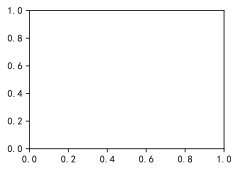

In [9]:
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

Found existing installation: d2l 1.0.3
Uninstalling d2l-1.0.3:
  Would remove:
    /root/miniconda3/envs/d2l/lib/python3.8/site-packages/d2l-1.0.3.dist-info/*
    /root/miniconda3/envs/d2l/lib/python3.8/site-packages/d2l/*
Proceed (Y/n)? ^C
ERROR: Operation cancelled by user
